In [ ]:
from google.colab import files
uploaded = files.upload()  # Opens file upload dialog

Saving final_preprocessed_data.csv to final_preprocessed_data.csv


In [ ]:
import pandas as pd

df = pd.read_csv("final_preprocessed_data.csv")  # Load uploaded file

df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-0.756450,-0.080555,-0.887220,0.207242,2.416118,2.586903,1.521106,-0.975096,-1.130560,1.595359,...,-1.224920,-0.499905,-0.460336,-1.019537,-0.137944,0.620807,0.909807,1.557280,2.552950,sad
1,1.599247,1.855606,-2.563416,1.001680,1.497387,-1.669671,-1.141146,-1.209192,-1.529407,-0.644377,...,-0.757056,0.529546,0.797697,0.405281,1.235196,0.961448,1.041838,1.742813,1.617229,angry
2,-4.684983,1.562893,0.781379,1.804534,2.364849,1.227898,0.546017,0.312357,-0.082968,1.300100,...,0.954061,0.140788,-0.213432,-0.321112,0.912375,1.762079,1.173572,0.538463,0.987126,disgust
3,-0.616899,-0.080653,-0.342846,1.034165,0.875514,-0.683095,0.833404,0.253707,-1.966081,-0.251808,...,-0.532205,0.429465,0.617555,-0.080381,0.770216,1.318908,1.024836,1.872452,2.978115,disgust
4,0.015079,1.005145,-0.827219,1.819852,2.169953,0.607013,0.102312,-1.716277,-1.121451,1.046999,...,-0.176075,-0.316824,-0.423309,0.031363,0.547154,0.522942,1.415464,2.187452,2.351905,happy


In [ ]:
df.shape

(7922, 41)

In [ ]:
# Remove "unknown" category
df_filtered = df[df["emotion"] != "unknown"]

# Verify new class distribution
print(df_filtered["emotion"].value_counts())

emotion
sad          1331
angry        1331
disgust      1331
happy        1331
fearful      1331
neutral       120
surprised      60
Name: count, dtype: int64


In [ ]:
df_filtered.shape

(6835, 41)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Extract features & labels after removing "unknown"
X = df_filtered.iloc[:, :-1].values
y = df_filtered["emotion"].values

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=df_filtered.columns[:-1])
df_balanced["emotion"] = y_resampled

# Verify class distribution after oversampling
print(df_balanced["emotion"].value_counts())

emotion
sad          1331
angry        1331
disgust      1331
happy        1331
surprised    1331
neutral      1331
fearful      1331
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Extract features and labels from the balanced dataset
X = df_balanced.iloc[:, :-1].values  # Features (all columns except last)
y = df_balanced["emotion"].values    # Labels (last column)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Convert emotion labels to numbers
y_categorical = to_categorical(y_encoded)  # Convert to one-hot encoding

# Split dataset: 80% Train, 10% Validation, 10% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Reshape for LSTM input: (samples, timesteps=1, features)
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print(f"Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}, Test Shape: {X_test.shape}")

Train Shape: (7453, 1, 40), Validation Shape: (932, 1, 40), Test Shape: (932, 1, 40)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # First LSTM Layer
    model.add(Dropout(0.3))  # Regularization
    model.add(LSTM(64))  # Second LSTM Layer
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))  # Fully connected layer
    model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Output Layer

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

# Initialize the model
model = build_lstm_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,247 (540.03 KB)

 Trainable params: 138,247 (540.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust epochs if needed
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4231 - loss: 1.5653 - val_accuracy: 0.5655 - val_loss: 1.0367
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5864 - loss: 1.0048 - val_accuracy: 0.5933 - val_loss: 0.9862
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6199 - loss: 0.9461 - val_accuracy: 0.6330 - val_loss: 0.9429
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6393 - loss: 0.8882 - val_accuracy: 0.6524 - val_loss: 0.9133
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6457 - loss: 0.8800 - val_accuracy: 0.6599 - val_loss: 0.8901
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6542 - loss: 0.8520 - val_accuracy: 0.6652 - val_loss: 0.8774
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6739 - loss: 0.8130 - val_accuracy: 0.6781 - val_loss: 0.8650
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6728 - loss: 0.8141 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6943 - loss: 0.7784
Test Accuracy: 67.81%


In [ ]:
model.save('ser_lstm_model.keras')

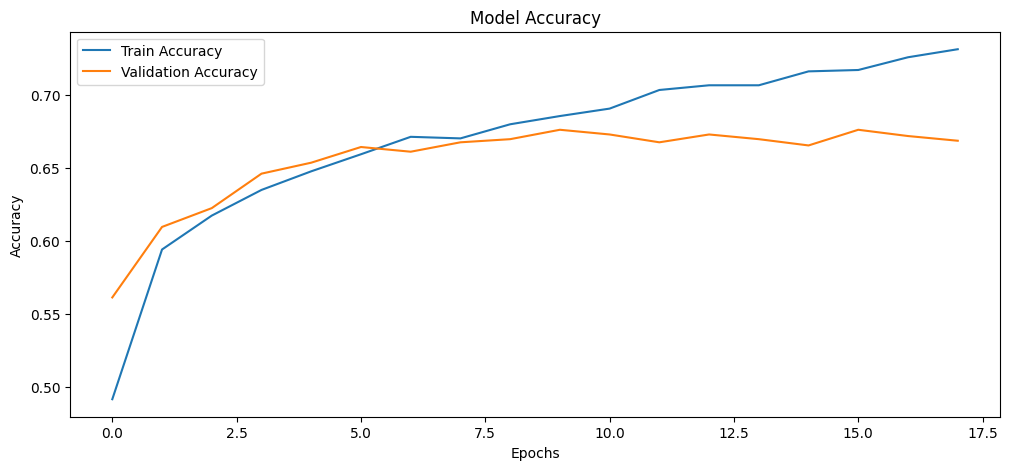

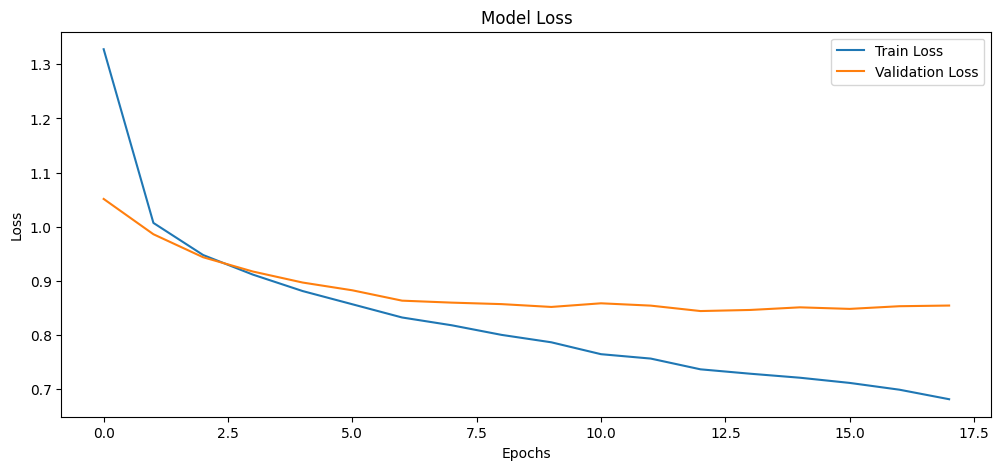

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def build_lstm_model():
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())  # Normalize activations
    model.add(Dropout(0.5))
    model.add(LSTM(128, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])
    return model

In [ ]:
import numpy as np

def add_noise(data, noise_level=0.005):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

X_train_noisy = add_noise(X_train)
X_val_noisy = add_noise(X_val)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_noisy, y_train,
    validation_data=(X_val_noisy, y_val),
    epochs=50,  # Adjust epochs if needed
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7235 - loss: 0.7147 - val_accuracy: 0.6620 - val_loss: 0.8464
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7253 - loss: 0.6844 - val_accuracy: 0.6642 - val_loss: 0.8407
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7277 - loss: 0.6766 - val_accuracy: 0.6652 - val_loss: 0.8478
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7379 - loss: 0.6717 - val_accuracy: 0.6599 - val_loss: 0.8495
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7419 - loss: 0.6449 - val_accuracy: 0.6609 - val_loss: 0.8582
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7285 - loss: 0.6762 - val_accuracy: 0.6631 - val_loss: 0.8637
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7440 - loss: 0.6518 - val_accuracy: 0.6642 - val_loss: 0.8649


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7118 - loss: 0.7832
Test Accuracy: 68.88%


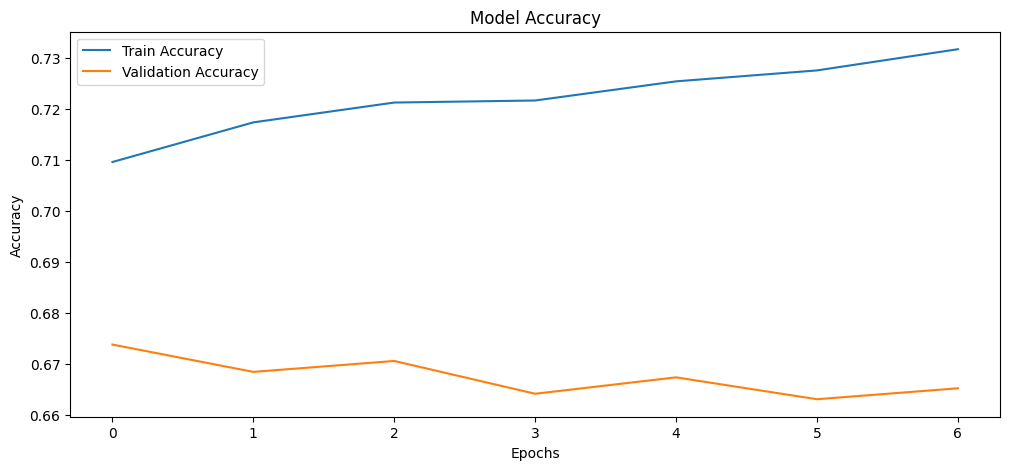

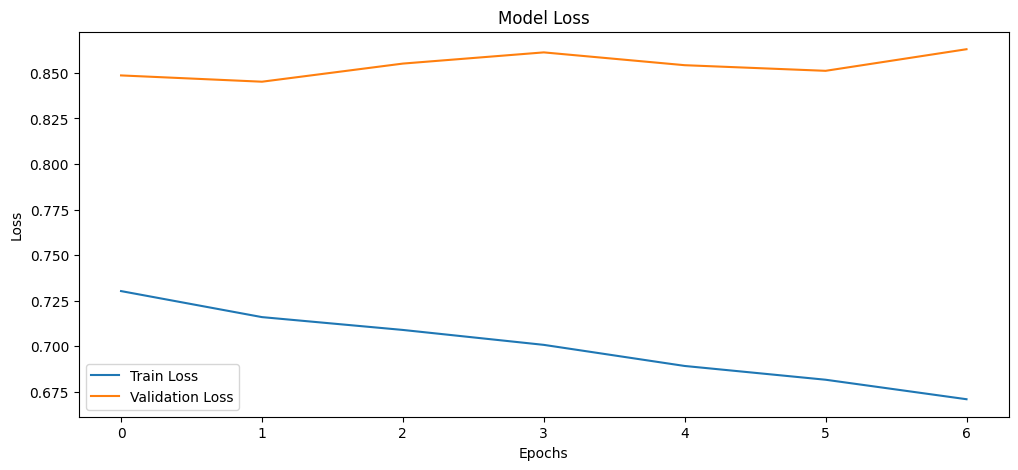

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

In [ ]:
from tensorflow.keras.regularizers import l2

def build_lstm_model():
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))  # Increased dropout
    model.add(LSTM(128, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])
    return model

In [ ]:
optimizer = Adam(learning_rate=0.0001)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_noisy, y_train,
    validation_data=(X_val_noisy, y_val),
    epochs=50,  # Adjust epochs if needed
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7309 - loss: 0.6747 - val_accuracy: 0.6642 - val_loss: 0.8545
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7322 - loss: 0.6706 - val_accuracy: 0.6663 - val_loss: 0.8510
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7425 - loss: 0.6642 - val_accuracy: 0.6642 - val_loss: 0.8619
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7366 - loss: 0.6515 - val_accuracy: 0.6685 - val_loss: 0.8653
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7497 - loss: 0.6330 - val_accuracy: 0.6620 - val_loss: 0.8579
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7543 - loss: 0.6196 - val_accuracy: 0.6685 - val_loss: 0.8671
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7455 - loss: 0.6327 - val_accuracy: 0.6599 - val_loss: 0.8677


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_advanced_lstm():
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(BatchNormalization())  # Normalize activations
    model.add(Dropout(0.4))  # Regularization

    # Second LSTM layer
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Third LSTM layer
    model.add(LSTM(64))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Flatten before fully connected layers
    model.add(Flatten())

    # Dense layers
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))

    # Output layer
    model.add(Dense(y_categorical.shape[1], activation="softmax"))

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

# Initialize the improved model
advanced_model = build_advanced_lstm()
advanced_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 1, 256)              │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 569,479 (2.17 MB)

 Trainable params: 568,583 (2.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
# Train the model with dynamic learning rate adjustment
history = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Increase epochs for better training
    batch_size=32,
    callbacks=[reduce_lr]
)

Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7008 - loss: 0.7523 - val_accuracy: 0.6749 - val_loss: 0.8338 - learning_rate: 7.8125e-06
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7072 - loss: 0.7505 - val_accuracy: 0.6727 - val_loss: 0.8340 - learning_rate: 7.8125e-06
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.6945 - loss: 0.7726 - val_accuracy: 0.6760 - val_loss: 0.8337 - learning_rate: 7.8125e-06
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7001 - loss: 0.7654 - val_accuracy: 0.6781 - val_loss: 0.8326 - learning_rate: 7.8125e-06
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7011 - loss: 0.7483 - val_accuracy: 0.6749 - val_loss: 0.8347 - learning_rate: 7.8125e-06
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7034 - loss: 0.7615 - val_accuracy: 0.6760 - val_loss: 0.8336 - learning_rate: 7.8125e-06
Epoch 7/50
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc

In [ ]:
test_loss, test_acc = advanced_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6960 - loss: 0.7817
Test Accuracy: 67.60%


In [ ]:
# Train the model with dynamic learning rate adjustment
history = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increase epochs for better training
    batch_size=32,
    callbacks=[reduce_lr]
)

Epoch 1/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7001 - loss: 0.7564 - val_accuracy: 0.6749 - val_loss: 0.8339 - learning_rate: 7.2760e-15
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7042 - loss: 0.7451 - val_accuracy: 0.6760 - val_loss: 0.8340 - learning_rate: 7.2760e-15
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7067 - loss: 0.7589 - val_accuracy: 0.6760 - val_loss: 0.8336 - learning_rate: 7.2760e-15
Epoch 4/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7019 - loss: 0.7723 - val_accuracy: 0.6760 - val_loss: 0.8339 - learning_rate: 7.2760e-15
Epoch 5/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7118 - loss: 0.7472 - val_accuracy: 0.6760 - val_loss: 0.8336 - learning_rate: 7.2760e-15
Epoch 6/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7080 - loss: 0.7325
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.637978979886434e-15.
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - ac

In [ ]:
test_loss, test_acc = advanced_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6921 - loss: 0.7829
Test Accuracy: 67.27%
